In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import davies_bouldin_score, adjusted_mutual_info_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from pathlib import Path
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')

# Features Description


**Power:**

Description: Power measures the energy of the EEG signal within a particular frequency band (e.g., alpha, beta, theta).

Application: Power analysis helps to quantify the amount of neural activity occurring within a specific band. It’s often used to assess mental states, such as relaxation (alpha power) or alertness (beta power).

**Detrended Fluctuation Analysis (DFA):**

Description: DFA quantifies the self-similarity and scaling properties of a signal by removing trends and assessing the remaining fluctuations.

Application: DFA is often used to detect long-range temporal correlations in EEG data, which is relevant for studying brain dynamics and neurodegenerative diseases.

**Higuchi Fractal Dimension:**

Description: The Higuchi Fractal Dimension estimates the complexity or "roughness" of the EEG signal by computing its fractal dimension.

Application: It’s commonly used to assess signal complexity, which can reflect cognitive load or the overall dynamism in brain activity.

**Lviv Complexity:**

Description: Lviv Complexity is another measure of EEG signal complexity, but there’s limited standardization in its exact definition across studies.

Application: Typically used to analyze the irregularity or unpredictability of neural oscillations. It may be applied in contexts similar to entropy and fractal dimension measures.

**Approximate Entropy:**

Description: Approximate Entropy measures the regularity and predictability of fluctuations in a time series.

Application: Lower entropy indicates a more predictable signal, while higher entropy suggests complexity. In EEG, approximate entropy is used for understanding cognitive states and is linked to various conditions, including epilepsy.

**Power Ratio:**

Description: This is often the ratio of power between two frequency bands (e.g., theta/beta ratio).

Application: Power ratios are widely used to infer cognitive or emotional states. For instance, an increased theta/beta ratio has been associated with attention and focus deficits.

**Dominant Peak Frequency (DPF)**

Description: DPF refers to the frequency at which the EEG signal has the highest power or amplitude within a specified range. It’s essentially the dominant frequency component in the signal, or the "main" frequency where most neural activity is concentrated.

Application: DPF is a useful indicator of the primary oscillatory rhythm in a given EEG channel or region. In different brain states, the DPF shifts:

Alpha DPF (8-12 Hz) is often associated with relaxed or resting states.

Beta DPF (13-30 Hz) might appear during alertness and focused mental activity.

Theta DPF (4-7 Hz) can be more prominent during drowsiness or certain meditative states.

**FWHM (Full Width at Half Maximum):**

Description: FWHM measures the width of a peak in the frequency domain at half of its maximum amplitude.

Application: FWHM is used to assess the spectral width of frequency components, giving insight into the "sharpness" of a specific frequency band, which can reflect mental states and signal quality.


**Local Degree (Coh, PLV, PLI):**

Description: Local Degree represents connectivity measures in the EEG, assessed through metrics like coherence (Coh), phase-locking value (PLV), and phase-lag index (PLI).

Local Degree Coh: Measures how strongly EEG channels are coherently connected, or share frequencies.

Local Degree PLV: Reflects how consistently EEG channels lock phases with each other.

Local Degree PLI: Indicates the stability of phase lags between channels.

Application: These measures are used to analyze brain network connectivity at a local level, useful for understanding localized functional relationships between brain regions.

**Connection Strength (Coh, PLV, PLI):**

Description: Connection Strength measures the overall strength of connections between EEG channels using coherence, PLV, and PLI, similar to the Local Degree metrics.

Connection Strength Coh: Reflects the global coherence or shared frequency components across regions.

Connection Strength PLV: Shows the global level of consistent phase-locking across channels.

Connection Strength PLI: Measures the global stability of phase relationships between EEG channels.

Application: These metrics allow for a global understanding of brain connectivity, helping to reveal patterns of synchronization and desynchronization associated with cognitive states and neurological conditions.

# 1. DATA LOADING

In [2]:
import pandas as pd

# Define the file path
file_path = r"C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\MI\SUB_2\Dictionary.parquet"
save_path = r"C:\Users\Ferran\Desktop\TFM\TFM_EEG\notebooks\plots"

# Load the Parquet file
data = pd.read_parquet(file_path)

# Display the first few rows of the DataFrame
data


,channel,rms,ptp,skewness,kurtosis,hurst_exponent,fractal_dimension,delta_power,theta_power,alpha_power,beta_power,gamma_power,sample_entropy,permutation_entropy,shannon_entropy,lziv_complexity,side,subject
0,F3,22402.489518,56.615234,-0.921097,0.797954,0.734549,1.655248,1927.023306,1943.620864,1417.671336,599.837133,182.490460,1.614425,2.517384,3.381682,0.840,left,S001
1,Fz,36433.390710,77.179688,-0.256353,-0.389731,0.788290,1.588158,7999.322640,6679.598628,2407.579532,508.201181,205.256033,0.966188,2.452954,3.561598,0.952,left,S001
2,F4,7501.200811,89.749023,-0.445035,-0.997495,0.829845,1.777767,15551.121096,13180.163321,3696.373188,676.211193,247.659598,1.559137,2.559052,3.615582,0.928,left,S001
3,C3,30388.703612,62.505859,-0.532592,-0.336274,0.784874,1.579578,4720.484763,4077.481137,1628.718637,514.529368,222.217786,1.195703,2.494307,3.585478,0.928,left,S001
4,Cz,30612.126355,68.941406,-0.795338,0.041866,0.767606,1.585572,4452.871033,4095.047259,2122.044836,671.520178,286.959308,1.224493,2.481126,3.507718,0.928,left,S001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5325,C4,43137.308832,100.125000,-0.082038,-0.693493,0.753104,2.100187,10695.211484,7927.872011,2813.996379,150.813535,61.167578,1.624144,2.360933,3.624561,0.872,right,S008
5326,P3,56055.424115,57.664062,0.114045,-0.339438,0.760713,1.945683,3430.105266,2326.632177,1012.162588,63.331033,16.345778,2.468100,2.396545,3.506932,0.856,right,S008
5327,Pz,51032.768768,96.492188,-0.087045,-0.546134,0.712491,2.136316,5254.490075,3722.334313,1697.738255,106.728394,21.072037,2.101914,2.328037,3.545086,0.936,right,S008
5328,P4,42061.952640,77.980469,0.081020,-0.548523,0.680991,2.139927,3441.313146,2271.659240,1276.675791,120.097125,28.121161,2.174752,2.532906,3.523730,0.920,right,S008


In [3]:
print(data.head())
print(data.describe())
print(data.info())


  channel           rms        ptp  skewness  kurtosis  hurst_exponent  \
0      F3  22402.489518  56.615234 -0.921097  0.797954        0.734549   
1      Fz  36433.390710  77.179688 -0.256353 -0.389731        0.788290   
2      F4   7501.200811  89.749023 -0.445035 -0.997495        0.829845   
3      C3  30388.703612  62.505859 -0.532592 -0.336274        0.784874   
4      Cz  30612.126355  68.941406 -0.795338  0.041866        0.767606   

   fractal_dimension   delta_power   theta_power  alpha_power  beta_power  \
0           1.655248   1927.023306   1943.620864  1417.671336  599.837133   
1           1.588158   7999.322640   6679.598628  2407.579532  508.201181   
2           1.777767  15551.121096  13180.163321  3696.373188  676.211193   
3           1.579578   4720.484763   4077.481137  1628.718637  514.529368   
4           1.585572   4452.871033   4095.047259  2122.044836  671.520178   

   gamma_power  sample_entropy  permutation_entropy  shannon_entropy  \
0   182.490460      

**Balance analysis**

To be sure that we have an equilibred dataset, we can visualize how many instances are considered for Supination and how many for Close-Hand.

In [4]:
count_n_left = (data['side'] == 'left').sum()
count_n_right = (data['side'] == 'right').sum()
print("LEFT samples: " + str(count_n_left));
print("RIGHT hand samples: " + str(count_n_right));

LEFT samples: 2910
RIGHT hand samples: 2420


As it can be seen, more or less the number of samples is similar. We can say that the dataset is almost 50-50 for each case. 

In [5]:
data.describe()

,rms,ptp,skewness,kurtosis,hurst_exponent,fractal_dimension,delta_power,theta_power,alpha_power,beta_power,gamma_power,sample_entropy,permutation_entropy,shannon_entropy,lziv_complexity
count,5330.000000,5330.000000,5330.000000,5330.000000,5330.000000,5330.000000,5330.000000,5330.000000,5330.000000,5330.000000,5330.000000,5330.000000,5330.000000,5330.000000,5330.000000
mean,32694.306779,56.822620,0.051773,-0.459707,0.709395,1.965196,3071.423372,2417.335788,892.941774,123.599475,39.889320,1.750687,2.490345,3.543207,0.904348
std,17245.725322,27.921608,0.318184,0.502661,0.085824,0.198767,8809.573606,6802.405973,1819.005654,117.978814,53.895861,0.438383,0.088453,0.088434,0.052380
min,707.970005,11.631836,-1.755465,-1.668145,0.375691,1.230689,21.186328,27.319436,35.937497,11.613050,3.043590,0.139393,2.243125,2.865226,0.592000
25%,18784.444763,36.966370,-0.086325,-0.712195,0.659032,1.822445,629.116404,534.434345,319.721321,70.969468,19.654679,1.492517,2.406809,3.496560,0.880000
50%,32745.822839,51.522461,0.016677,-0.507944,0.726572,2.008233,1213.214005,986.064825,504.087620,102.557086,29.034705,1.757858,2.533292,3.551597,0.920000
75%,45689.294377,71.400269,0.166460,-0.282227,0.776229,2.127983,2477.291487,1958.114649,843.756995,147.242238,43.643494,2.014903,2.566095,3.603113,0.944000
max,65662.692537,362.476562,2.266841,8.957606,0.844978,2.288745,339223.311104,275671.138277,55598.876246,5117.049449,1386.076309,4.204693,2.577283,3.768089,0.984000


***Null values analysis***

To be 100% sure that there are no Nan values a further analysis has been performed.

In [6]:
data.isnull().sum()

channel                0
rms                    0
ptp                    0
skewness               0
kurtosis               0
hurst_exponent         0
fractal_dimension      0
delta_power            0
theta_power            0
alpha_power            0
beta_power             0
gamma_power            0
sample_entropy         0
permutation_entropy    0
shannon_entropy        0
lziv_complexity        0
side                   0
subject                0
dtype: int64

## 1.1 OUTLIERS DETECTION 

On this section,the outliers detection has been performed. It must be taken into account that all the data must be previously standarized in order to do the proper fitting. 

### 1.1.1 Standarize Data

In [7]:
from sklearn.preprocessing import StandardScaler

# Extract 'subject', 'side', and 'channel' columns to use later
subject = data['subject']
side = data['side']
channel = data['channel']

# Drop 'subject', 'side', and 'channel' columns to keep only the features
features_selected = data.drop(columns=['subject', 'side', 'channel'])

# Standardize the features
scaler = StandardScaler()
features_standardized = scaler.fit_transform(features_selected)

# Create DataFrame for standardized features
df_features_standardized = pd.DataFrame(features_standardized, columns=features_selected.columns)

# Combine 'subject', 'side', and 'channel' with standardized features
df_standardized = pd.concat([
    pd.DataFrame({
        'subject': subject.reset_index(drop=True),
        'side': side.reset_index(drop=True),
        'channel': channel.reset_index(drop=True)
    }),
    df_features_standardized
], axis=1)

# Create 'side_num' column based on 'side' values
df_standardized['side_num'] = df_standardized['side'].map({'left': 0, 'right': 1})

# Display the updated DataFrame
df_standardized.head()




,subject,side,channel,rms,ptp,skewness,kurtosis,hurst_exponent,fractal_dimension,delta_power,theta_power,alpha_power,beta_power,gamma_power,sample_entropy,permutation_entropy,shannon_entropy,lziv_complexity,side_num
0,S001,left,F3,-0.596831,-0.007428,-3.057862,2.502241,0.293110,-1.559499,-0.129916,-0.069646,0.288498,4.037016,2.646113,-0.310857,0.305722,-1.826680,-1.228596,0
1,S001,left,Fz,0.216833,0.729148,-0.968481,0.139224,0.919348,-1.897064,0.559432,0.626640,0.832752,3.260228,3.068552,-1.789697,-0.422763,0.207981,0.909812,0
2,S001,left,F4,-1.460969,1.179355,-1.561533,-1.069983,1.403581,-0.943045,1.416739,1.582357,1.541334,4.684431,3.855394,-0.436988,0.776839,0.818486,0.451582,0
3,S001,left,C3,-0.133704,0.203562,-1.836736,0.245581,0.879541,-1.940232,0.187207,0.244076,0.404532,3.313871,3.383295,-1.266097,0.044796,0.478043,0.451582,0
4,S001,left,Cz,-0.120747,0.434070,-2.662585,0.997930,0.678319,-1.910075,0.156827,0.246658,0.675764,4.644665,4.584641,-1.200420,-0.104230,-0.401337,0.451582,0


Once the data has been standarized, it's time to plot the outliers with the use of automatic tools such as DBSCAN or OPTICS that are two Density-based algorithms that are very good to detect automatically outliers. 

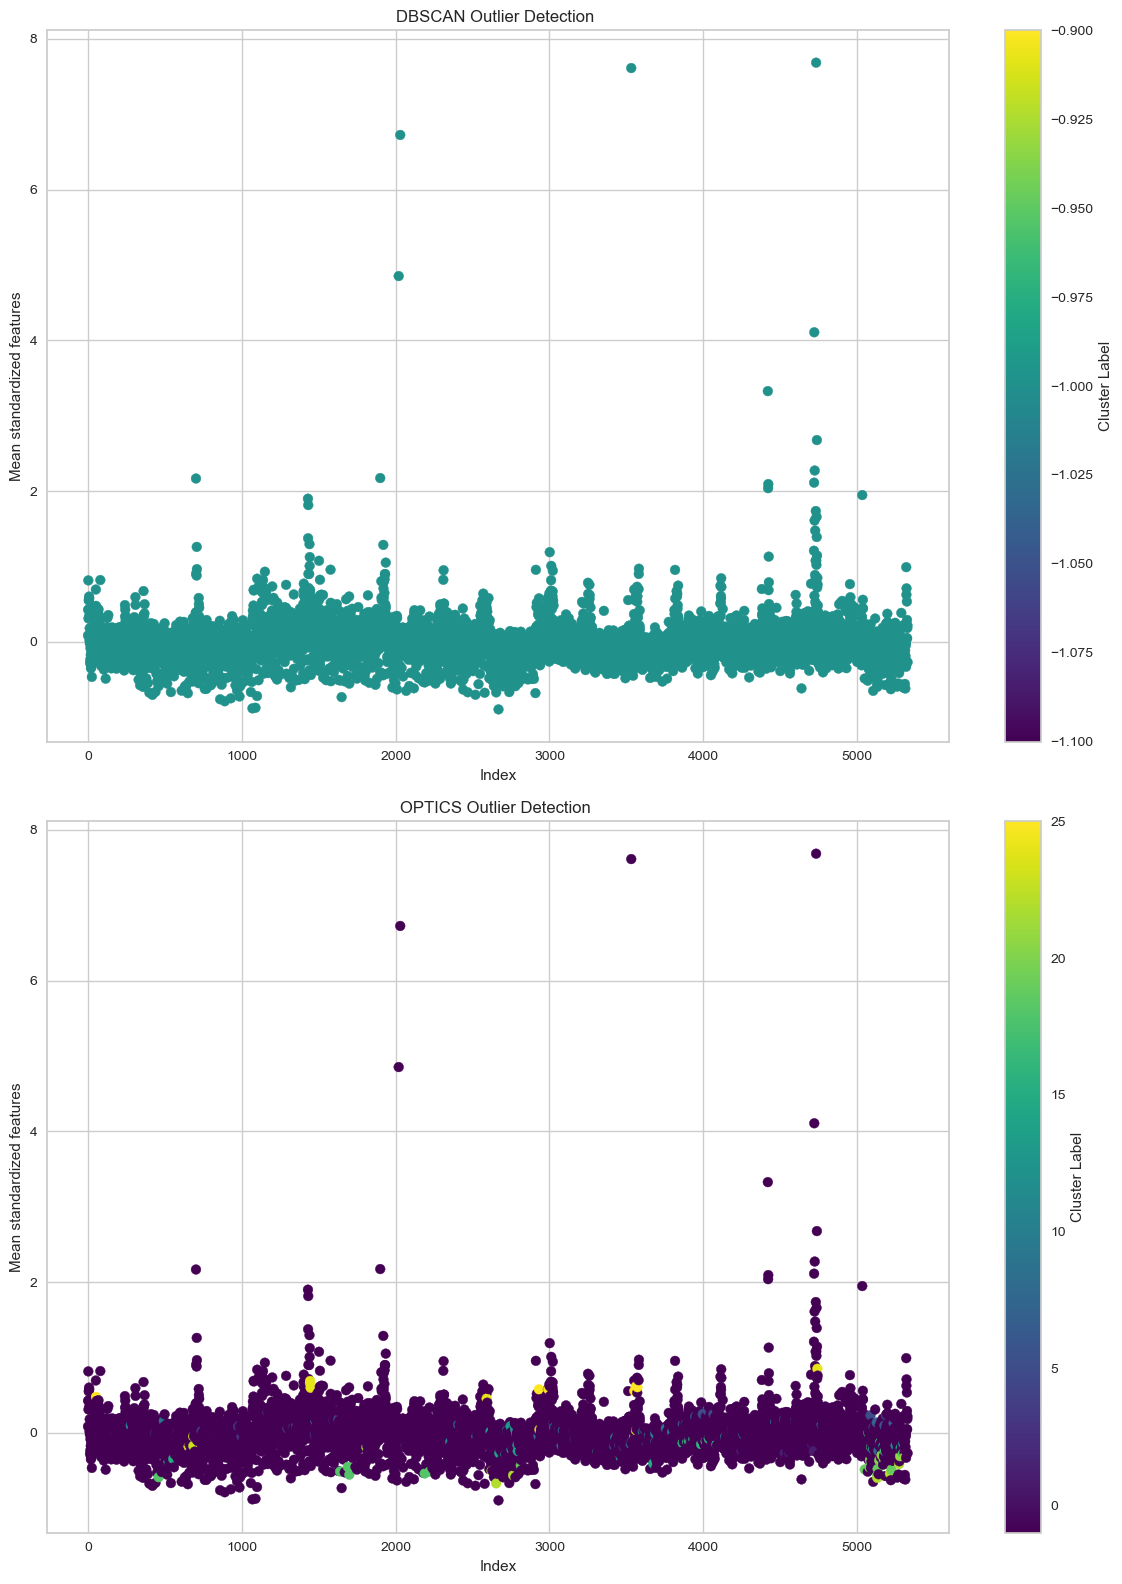

In [8]:
# Function to plot outliers
def outliers_plot(ax, features_df, outliers, model='', extra_feature=''):
    scatter = ax.scatter(range(len(features_df)), features_df.mean(axis=1), c=outliers, cmap='viridis')
    ax.set_xlabel('Index')
    ax.set_ylabel('Mean standardized features')
    ax.set_title(f'{model} Outlier Detection {extra_feature}')
    plt.colorbar(scatter, ax=ax, label='Cluster Label')

# Impute missing values
imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features_standardized)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
outliers_dbscan = dbscan.fit_predict(features_imputed)

# Apply OPTICS clustering
optics = OPTICS(min_samples=5)
labels_optics = optics.fit_predict(features_imputed)

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 16))

# Visualization for DBSCAN
outliers_plot(axes[0], features_imputed, outliers_dbscan, 'DBSCAN')

# Visualization for OPTICS
outliers_plot(axes[1], features_imputed, labels_optics, 'OPTICS')

# Adjust layout and display
plt.tight_layout()
plt.show()

# Extract outliers (data points labeled as -1 by OPTICS)
outliers_indices_optics = np.where(labels_optics == -1)[0]
outliers_optics = features_imputed[outliers_indices_optics]


**Correlation Matrix**

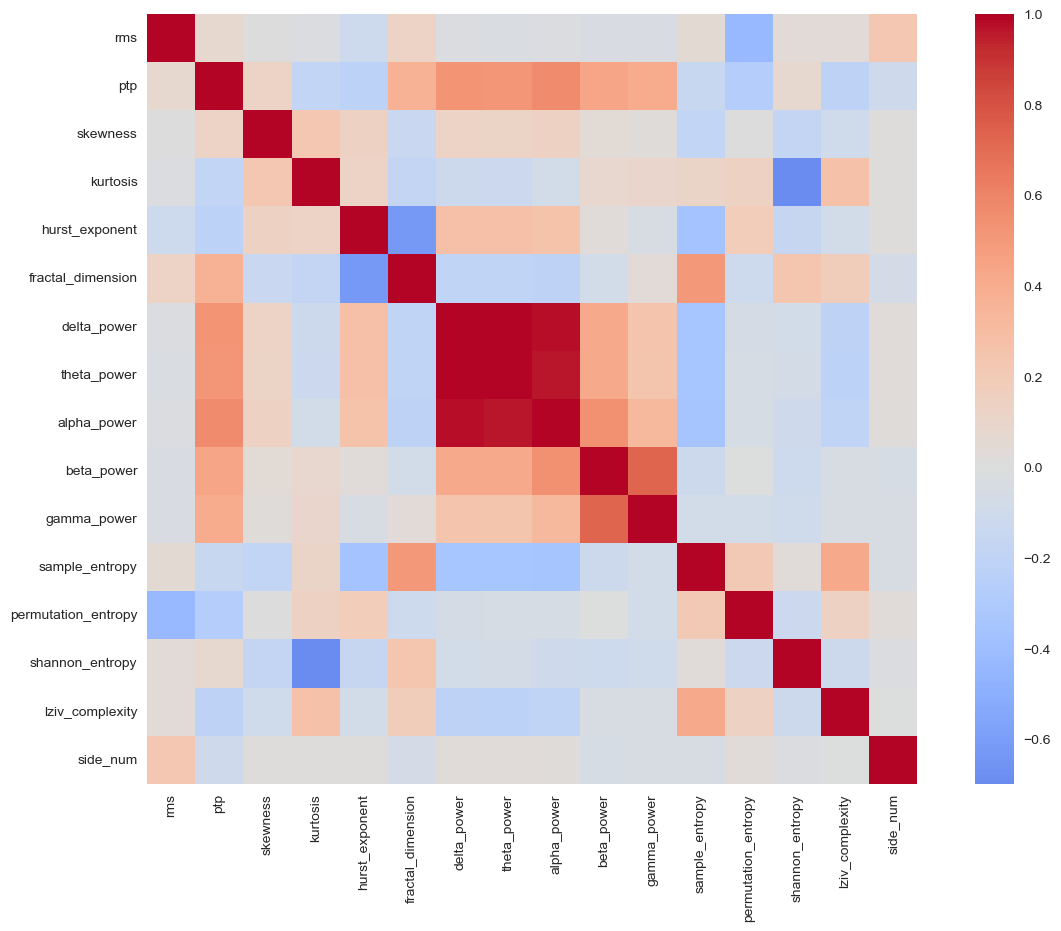

In [9]:
fig, ax = plt.subplots(figsize=(15, 10))  # Create a single axis
corrmat = df_standardized.corr(numeric_only=True)
sns.heatmap(corrmat, annot=False, square=True, cmap="coolwarm", center=0);

In [10]:
# Define the features to plot
features = ['rms','ptp','delta_power', 'theta_power', 'alpha_power', 'beta_power', 'gamma_power', 'hurst_exponent', 'fractal_dimension', 'kurtosis', 'skewness', 'sample_entropy',	'permutation_entropy',	'shannon_entropy'	,'lziv_complexity' ]

**Joint Histograms**

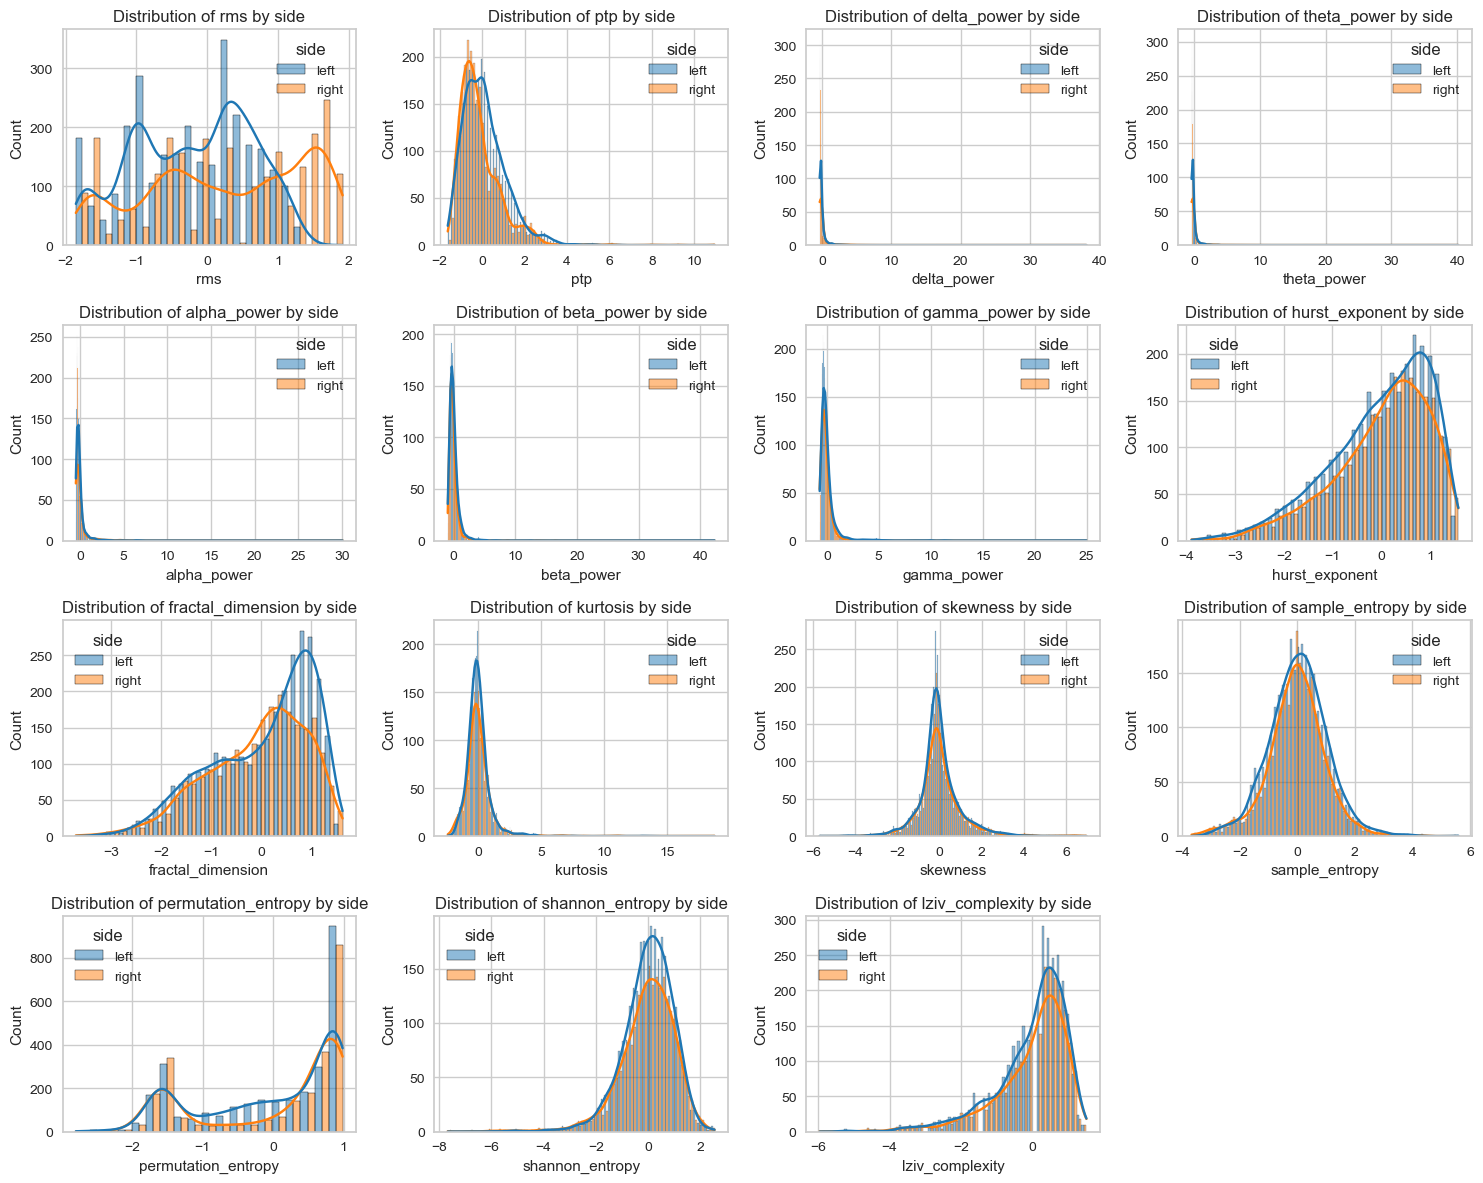

In [11]:
# Define a custom color palette
custom_colors = ['#1f77b4', '#ff7f0e']  # Example: blue and orange

# Create subplots 
fig, axes = plt.subplots(4, 4, figsize=(15, 12))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each feature
for i, feature in enumerate(features):
    sns.histplot(data=df_standardized, x=feature, hue="side", multiple="dodge", ax=axes[i], kde=True, palette=custom_colors)
    axes[i].set_title(f'Distribution of {feature} by side')

# Remove any unused subplot axes (since we only have 7 plots in an 8-slot grid)
for j in range(len(features), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

**Density Plot**

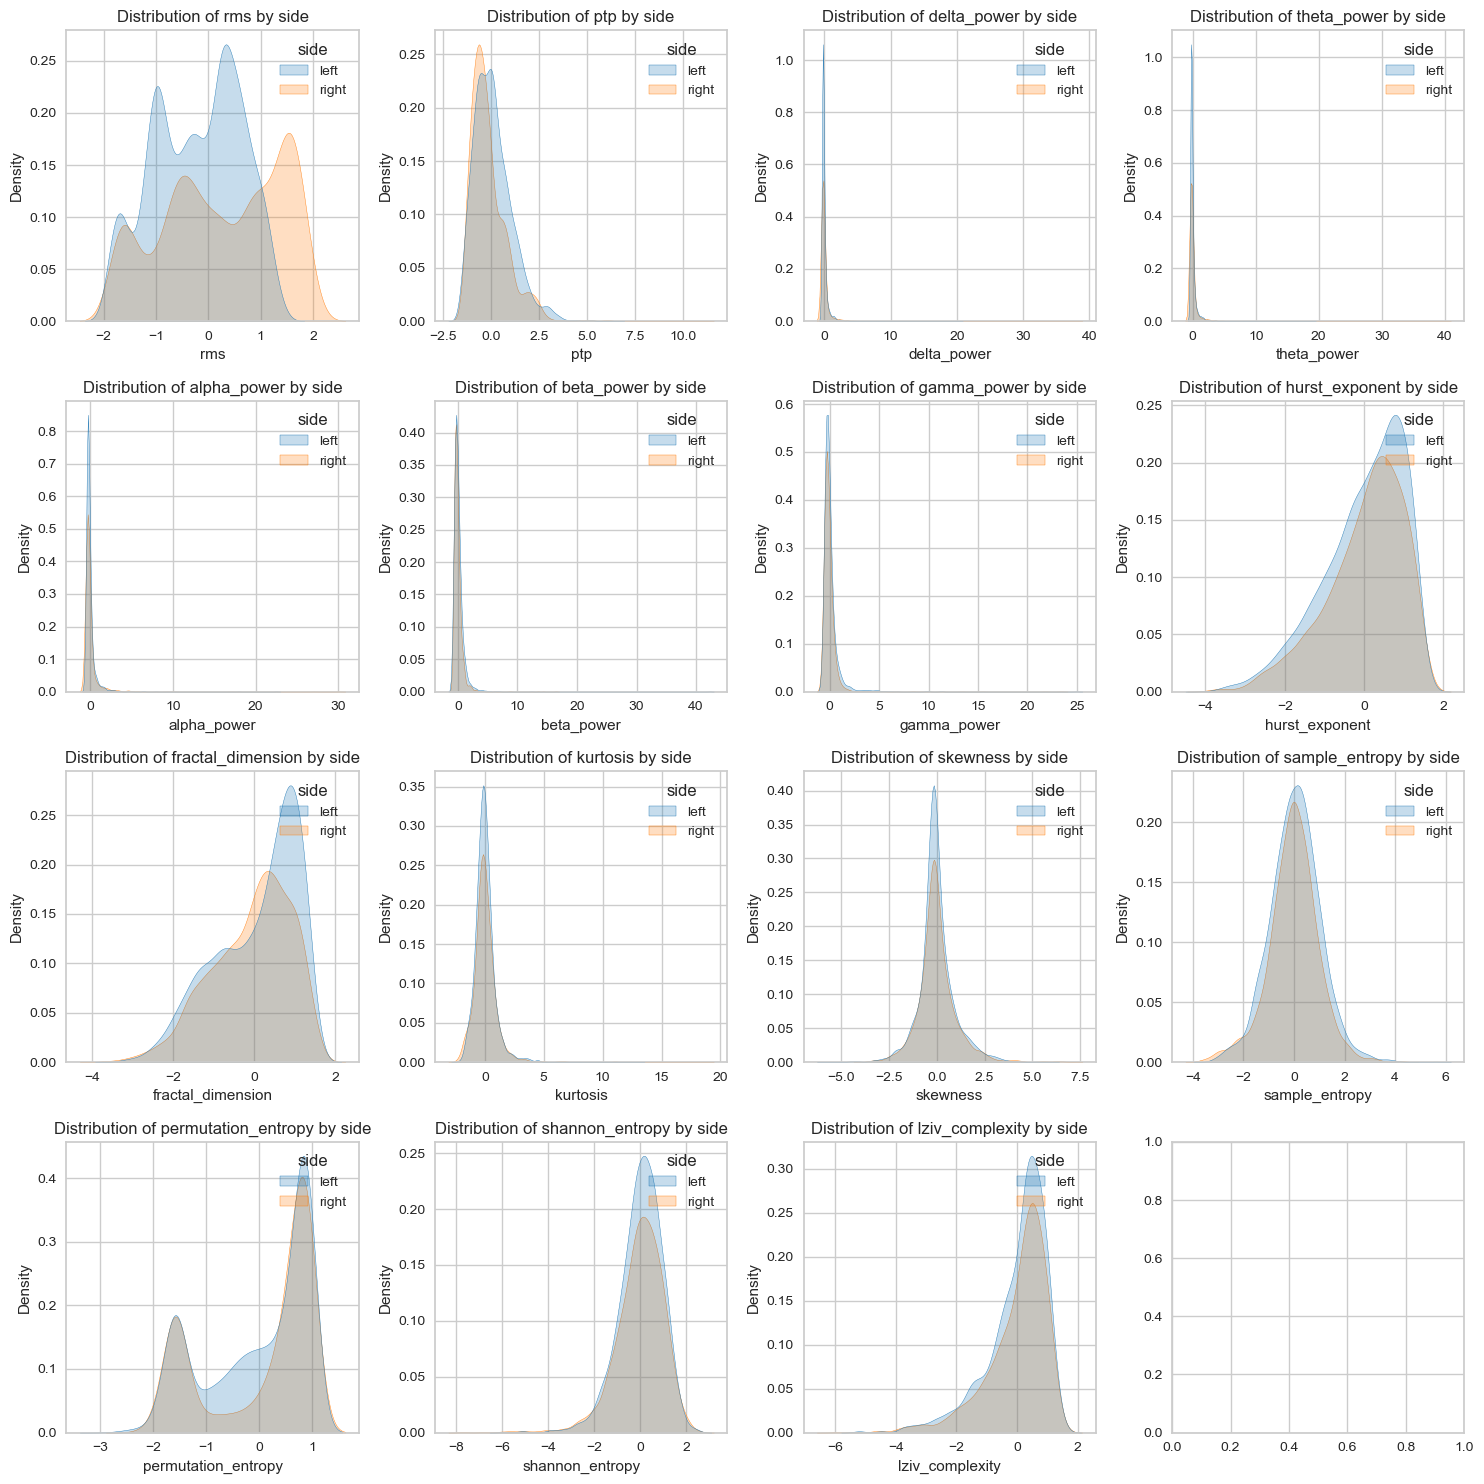

In [12]:
# Create subplots
fig, axes = plt.subplots(4, 4, figsize=(15, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each feature
for i, feature in enumerate(features):
    sns.kdeplot(data=df_standardized, x=feature, hue="side", fill=True, ax=axes[i],palette=custom_colors)
    axes[i].set_title(f'Distribution of {feature} by side')

# Adjust layout
plt.tight_layout()
plt.show()

## Comparison between features

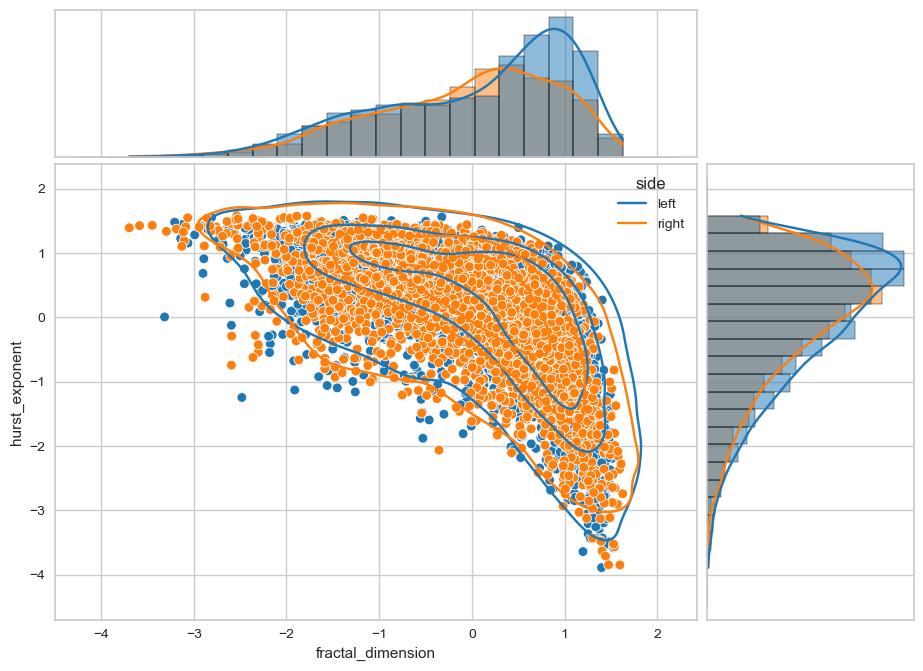

In [13]:
# Create the joint plot with a more visible color palette
g = sns.jointplot(data=df_standardized, x="fractal_dimension", y="hurst_exponent", hue="side", ratio=3, space=0.05,palette=custom_colors)
g.plot_joint(sns.kdeplot, levels=4)
g.plot_marginals(sns.histplot, bins=20, kde=True)
sns.despine(top=False, right=False)
g.fig.set_figheight(7)
g.fig.set_figwidth(10)
plt.show()

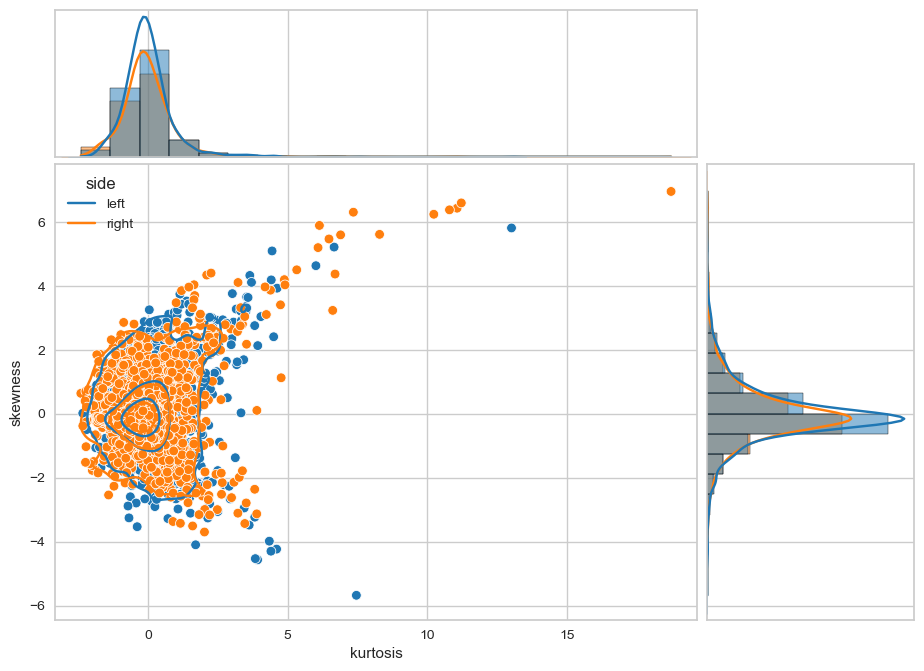

In [14]:
# Create the joint plot with a more visible color palette
g = sns.jointplot(data=df_standardized, x="kurtosis", y="skewness", hue="side", ratio=3, space=0.05,palette=custom_colors)
g.plot_joint(sns.kdeplot, levels=4)
g.plot_marginals(sns.histplot, bins=20, kde=True)
sns.despine(top=False, right=False)
g.fig.set_figheight(7)
g.fig.set_figwidth(10)
plt.show()

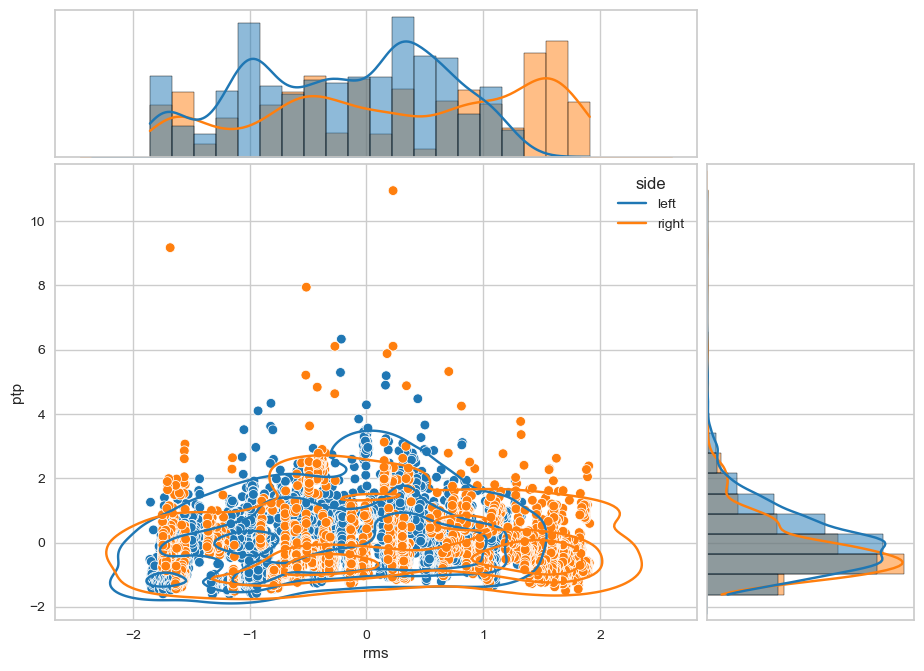

In [15]:
# Create the joint plot with a more visible color palette
g = sns.jointplot(data=df_standardized, x="rms", y="ptp", hue="side", ratio=3, space=0.05,palette=custom_colors)
g.plot_joint(sns.kdeplot, levels=4)
g.plot_marginals(sns.histplot, bins=20, kde=True)
sns.despine(top=False, right=False)
g.fig.set_figheight(7)
g.fig.set_figwidth(10)
plt.show()

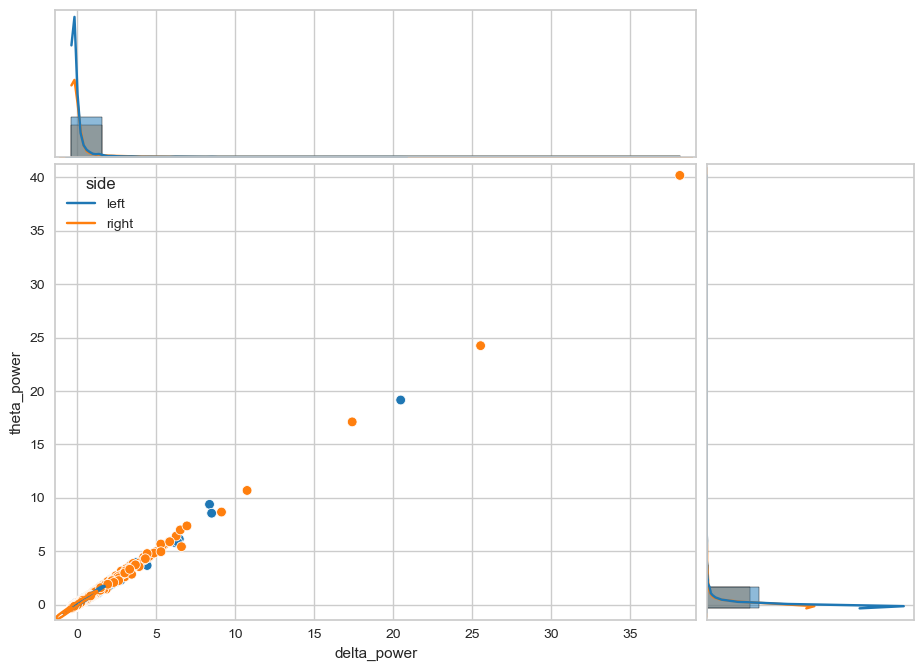

In [16]:
# Create the joint plot with a more visible color palette
g = sns.jointplot(data=df_standardized, x="delta_power", y="theta_power", hue="side", ratio=3, space=0.05,palette=custom_colors)
g.plot_joint(sns.kdeplot, levels=4)
g.plot_marginals(sns.histplot, bins=20, kde=True)
sns.despine(top=False, right=False)
g.fig.set_figheight(7)
g.fig.set_figwidth(10)
plt.show()

## CASE 1: Features extracted directly from raw EEG signals

Despite not having good features, in order to be sure that these are not useful for a high accuracy classification, Model Training and Hyperparameter tuning has been performed for the Case 1. 

The first thing that must be done in order to be sure that the data is balanced consists on feature scaling, this is done with the following code:

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Divide dataset into features and target
X = df_standardized[['rms', 'ptp', 'delta_power', 'theta_power', 'alpha_power', 'beta_power', 
                     'gamma_power', 'hurst_exponent', 'fractal_dimension', 'kurtosis', 'skewness', 'sample_entropy', 'permutation_entropy', 'shannon_entropy', 'lziv_complexity']]
y = df_standardized[['side']]

# Feature scaling
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

# Convert to dataframe
df_hfo_PAT1_st = pd.DataFrame(X_scaled, columns=X.columns)
df_hfo_PAT1_st = pd.concat([df_hfo_PAT1_st, y], axis=1)

# Split the data into 60% training and 40% testing
X_train, X_test, y_train, y_test = train_test_split(df_hfo_PAT1_st.drop('side', axis=1), 
                                                    df_hfo_PAT1_st['side'], 
                                                    test_size=0.4, 
                                                    random_state=42, 
                                                    stratify=df_hfo_PAT1_st['side'])

# Check the resulting sizes
print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")


Training set size: 3198
Testing set size: 2132


One question that will appear once we have our data is in how many clusters should we divide it to have good results using clustering and classification methods later on. To do so, the Elbow Method allows a detection of the optimum number of clusters with the following lines of code:

### Elbow Method

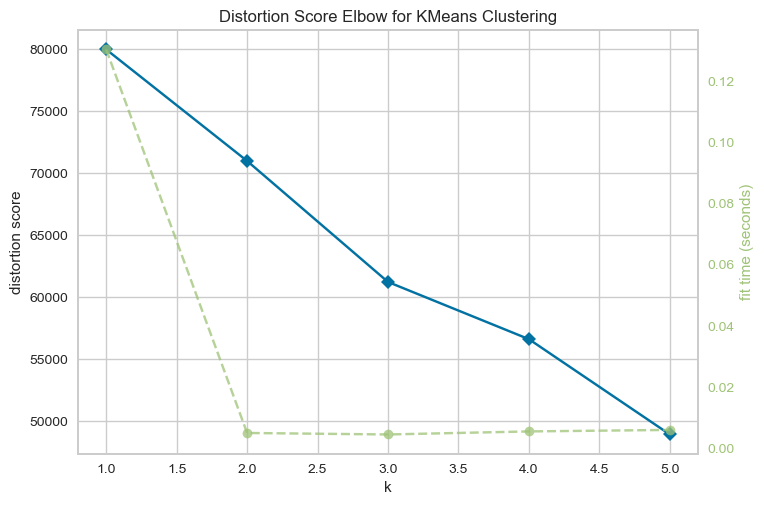

In [18]:
km = KMeans(n_init="auto")
elbow = KElbowVisualizer(km, k=(1, 6))
elbow.fit(X_scaled)
elbow.show();

### Silhouette Plots

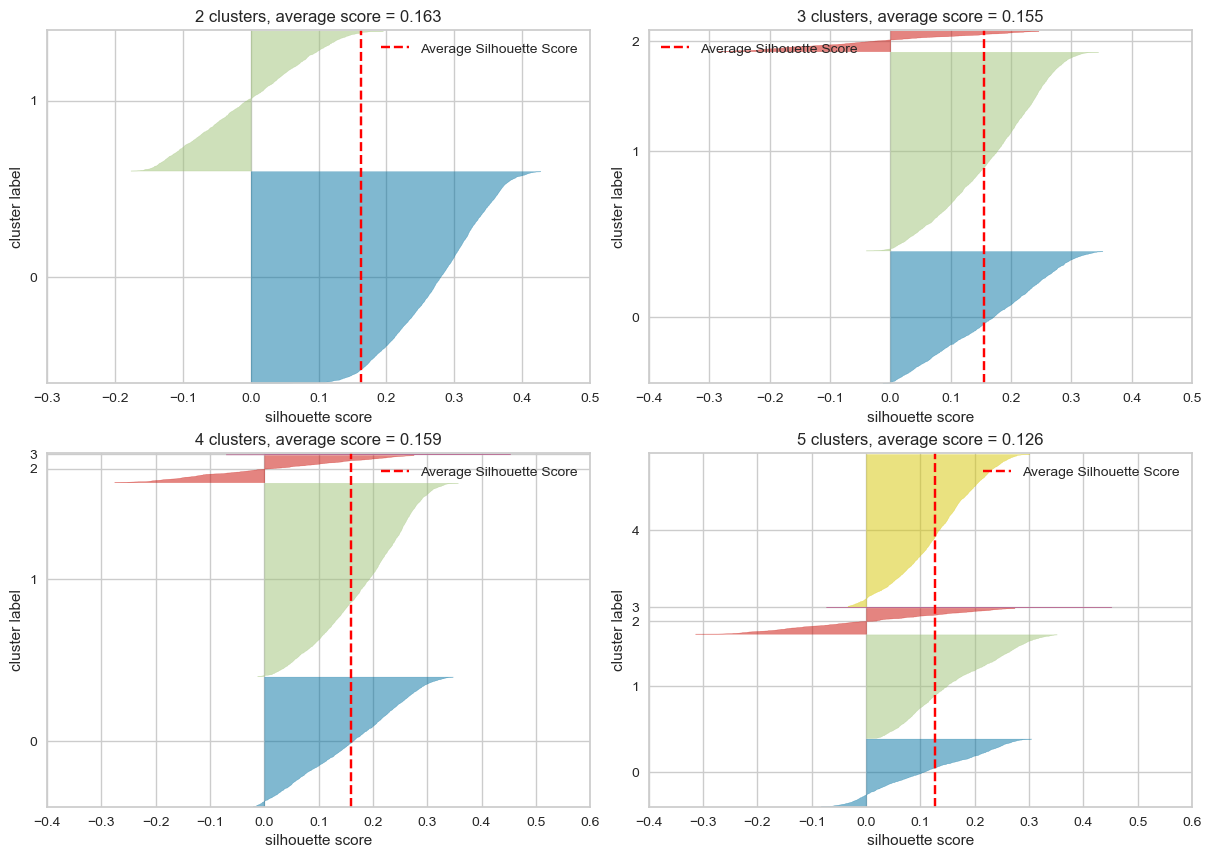

In [19]:
# Set figure layout
fig4 = plt.figure(constrained_layout=True, figsize=(12, 12))
gs = fig4.add_gridspec(3, 2)
ax411 = fig4.add_subplot(gs[0, 0])
ax412 = fig4.add_subplot(gs[0, 1])
ax413 = fig4.add_subplot(gs[1, 0])
ax421 = fig4.add_subplot(gs[1, 1])
ax_list = [ax411, ax412, ax413, ax421]

# Evaluate silhouette plots for 2 to 5 clusters
for i, n_clusters in enumerate(range(2, 6)):
    km = KMeans(n_clusters, n_init="auto", random_state=42)
    viz = SilhouetteVisualizer(km, ax=ax_list[i],
                               colors='yellowbrick')
    viz.fit(X)
    viz.finalize()
    viz.ax.set_title(
        f"{n_clusters} clusters, average score = {viz.silhouette_score_:0.3f}")
    viz.ax.set_xlabel("silhouette score")

On this analysis it can be seen that the "optimum" number of clusters is 2. On this case it makes sense, because we want to detect 2 groups, 'Right' and 'Left'

### CLUSTERING ALGORITHM TRIALS 

Having an "optimum" number of clusters equal to 2, two clusters have been chosen in order to match Right and Left Hemisphere. Once the number of clusters has been selected, Clustering Algorithm Trials can start, on this part two clustering methods have been tested in order to try to visualize if the dataset has some good results by clustering the data (more tests have been performed on Case 3). 

#### K-Means
The first method used is K-Means. This method minimizes the variance within each cluster, creating clusters of data points that are similar to each other. The amount of clusters will depend on the number of '*K*' initial centroids that will be chosen randomly from all the data. The following code implements the K-Means method. 

In [20]:
# Fit clustering and extract assigned clusters
km2 = KMeans(n_clusters=2, n_init="auto", random_state=42)
km2.fit(X_scaled)
df_standardized['2-means'] = km2.labels_


# Adjusted plotting function with simplified steps
def plot_data_clusters(ax, df_standardized, x, y, hue, title):
    # Check if hue is a list or array (indicating cluster labels)
    if isinstance(hue, (list, np.ndarray)):
        df_standardized['cluster_labels'] = hue
        hue = 'cluster_labels'
    
    print(f"Plotting {title} with hue: {hue}")
    print(df_standardized[[x, y, hue]].dropna().head())  # Print first few rows of data to be plotted

    sns.scatterplot(data=df_standardized,
                    x=x, y=y,
                    hue=hue,
                    palette="deep",
                    ax=ax)
    ax.set_title(title, size=14)

    # Adding KDE plot separately to handle potential issues
    try:
        sns.kdeplot(data=df_standardized,
                    x=x, y=y,
                    hue=hue,
                    alpha=0.5,
                    levels=3,
                    palette="deep",
                    ax=ax)
    except Exception as e:
        print(f"Failed to plot KDE: {e}")

In [21]:
print(df_standardized.head())

  subject  side channel       rms       ptp  skewness  kurtosis  \
0    S001  left      F3 -0.596831 -0.007428 -3.057862  2.502241   
1    S001  left      Fz  0.216833  0.729148 -0.968481  0.139224   
2    S001  left      F4 -1.460969  1.179355 -1.561533 -1.069983   
3    S001  left      C3 -0.133704  0.203562 -1.836736  0.245581   
4    S001  left      Cz -0.120747  0.434070 -2.662585  0.997930   

   hurst_exponent  fractal_dimension  delta_power  theta_power  alpha_power  \
0        0.293110          -1.559499    -0.129916    -0.069646     0.288498   
1        0.919348          -1.897064     0.559432     0.626640     0.832752   
2        1.403581          -0.943045     1.416739     1.582357     1.541334   
3        0.879541          -1.940232     0.187207     0.244076     0.404532   
4        0.678319          -1.910075     0.156827     0.246658     0.675764   

   beta_power  gamma_power  sample_entropy  permutation_entropy  \
0    4.037016     2.646113       -0.310857             

In [22]:
#['rms','ptp','delta_power', 'theta_power', 'alpha_power', 'beta_power', 'gamma_power', 'hurst_exponent', 'fractal_dimension', 'kurtosis', 'skewness']]

Plotting Labelled Data with hue: side
        ptp  side_num  side
0 -0.007428         0  left
1  0.729148         0  left
2  1.179355         0  left
3  0.203562         0  left
4  0.434070         0  left
Failed to plot KDE: cannot do a non-empty take from an empty axes.
Plotting Clustered Data with hue: 2-means
        ptp  side_num  2-means
0 -0.007428         0        1
1  0.729148         0        1
2  1.179355         0        1
3  0.203562         0        1
4  0.434070         0        1


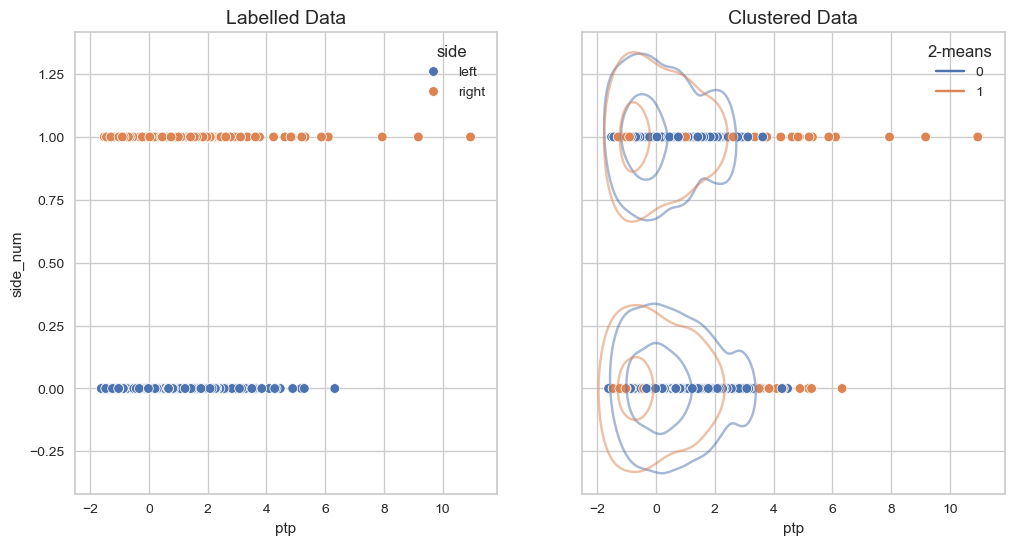

In [23]:
# Create a figure to compare labels and clusters
fig1, (ax11, ax12) = plt.subplots(
    nrows=1, ncols=2,
    sharex='all', sharey='all',
    figsize=(12, 6))

# Plotting labelled data
plot_data_clusters(ax11, df_standardized, 'ptp', 'side_num', 'side', 'Labelled Data')

# Plot clustered data
plot_data_clusters(ax12, df_standardized, 'ptp', 'side_num', '2-means', 'Clustered Data')


#### Hierarchical Clustering

The second method tested is Hierarchical Clustering, which aims to build a hierarchy of clusters. For this part, the Agglomerative (Bottom-Up) Approach was chosen. This approach starts with each data point as its own cluster and iteratively merges the closest pairs of clusters until all data points belong to a single cluster.

Plotting Labelled Data with hue: side
        ptp  side_num  side
0 -0.007428         0  left
1  0.729148         0  left
2  1.179355         0  left
3  0.203562         0  left
4  0.434070         0  left
Failed to plot KDE: cannot do a non-empty take from an empty axes.
Plotting Clustered Data with hue: Cluster
        ptp  side_num  Cluster
0 -0.007428         0        1
1  0.729148         0        1
2  1.179355         0        1
3  0.203562         0        1
4  0.434070         0        1


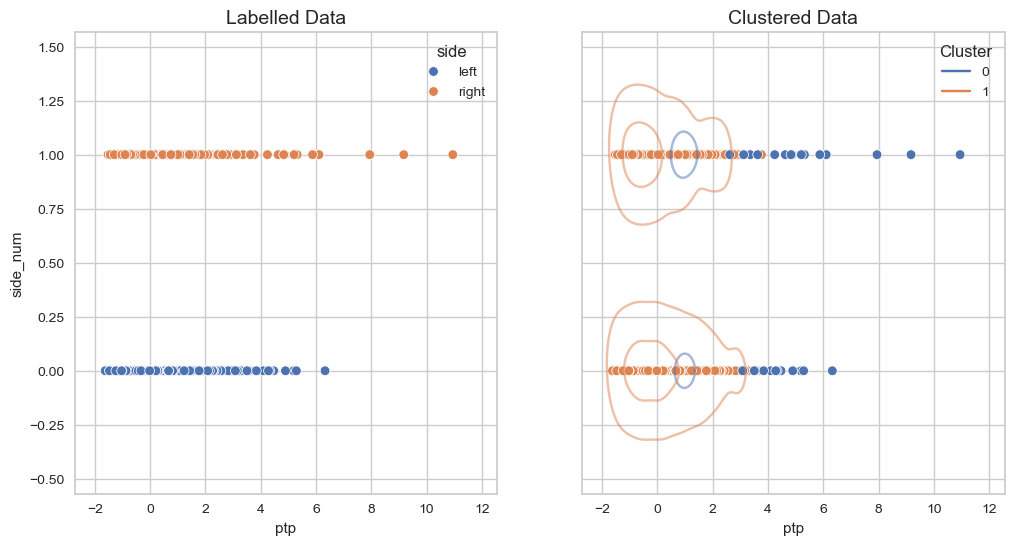

In [24]:
# Perform Agglomerative Clustering
agg = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward')
agg.fit(X_scaled)

# Add clustering labels to the dataset for plotting
df_standardized['Cluster'] = agg.labels_

# Create a figure to compare labels and clusters
fig5, (ax51, ax52) = plt.subplots(
    nrows=1, ncols=2,
    sharex='all', sharey='all',
    figsize=(12, 6))

# Plotting labelled data
plot_data_clusters(ax51, df_standardized, 'ptp', 'side_num', 'side', 'Labelled Data')

# Plot clustered data
plot_data_clusters(ax52, df_standardized, 'ptp', 'side_num', 'Cluster', 'Clustered Data')

# Show the plot
plt.show()


As it can be seen, the clustering algorithms are not a really good technique to solve this kind of problematic. To do further research some classification algorithms have been tested. 

### CLASSIFICATION

Once the dataset has been studied and analyzed if the different clustering methods are good options to separate into groups the different points some classification algorithms have been tested in order to find an improvement on the previous results. 

The first thing that must be done when working with classification algorithms is to divide the dataset into **Training and Testing**. For this purpose the dataset has been divided into 60% Training and 40% Test. In order to do this in python, the following code has been used.

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from pathlib import Path
from sklearn.impute import SimpleImputer

from yellowbrick.model_selection import ValidationCurve, LearningCurve, validation_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
from yellowbrick.classifier import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [26]:
# Divide dataset into train and test subsets           

selected_predictors = ['rms','ptp','delta_power', 'theta_power', 'alpha_power', 'beta_power', 'gamma_power', 'hurst_exponent', 'fractal_dimension', 'kurtosis', 'skewness',  'sample_entropy',	'permutation_entropy',	'shannon_entropy'	,'lziv_complexity' ]
#selected_predictors = ['rms', 'theta_power', 'alpha_power', 'beta_power', 'gamma_power', 'hurst_exponent', 'fractal_dimension', 'kurtosis', 'skewness',  'sample_entropy',	'permutation_entropy',	'shannon_entropy'	,'lziv_complexity' ]

X = df_standardized[selected_predictors]
y = df_standardized['side_num']

# Split the dataset into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)

# Impute missing values instead of dropping, when dropping some issues appeared
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

Once the dataset is been separated between Training and Testing data, some algorithms can be tested in order to visualize the accuracy and analyze the results obtained. 

## CLASSIFICATION ALGORITHMS

In [27]:
# Definition of functions used on the different algorithms. Mostly used to analyze the results analytically and visually. 

def study_model(model, X, y, param_name,param_range):
    
    sizes = np.linspace(0.1, 1.0, 10)    
        
    # Validation curve

    vc = ValidationCurve(
        model, param_name=param_name,
        param_range=param_range, cv=10, scoring="r2"
    )
       
        
    vc.fit(X, y)
    vc.show()

    # Learning Curve
    lc = LearningCurve(
        model, cv=10, scoring='f1_weighted', train_sizes=sizes, n_jobs=4
    )

    lc.fit(X, y)
    lc.show()           

    return model
    
def binary_classification(model, X_train, y_train, X_test, y_test):
    # Train model, use it to predict
    y_pred = model.fit(X_train, y_train).predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of positive class
    
    # Calculate evaluation metrics
    cm = confusion_matrix(model,
                      X_train,
                      y_train,
                      X_test,
                      y_test,
                      is_fitted=True,
                      support=True,
                      cmap='RdYlGn')
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Display results
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("Roc AUC score:", roc_auc)
    
    # Roc curve
    # Calculate the false positive rate, true positive rate, and thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='b', label='ROC Curve')
    plt.plot([0, 1], [0, 1], color='r', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
        
    # Classification report
    print(classification_report(y_pred, y_test))
    
    return model

In [28]:
def evaluate_classifier(model, X_train_imputed, y_train, X_test_imputed, y_test):
    # Train model, use it to predict
    y_pred = model.fit(X_train_imputed, y_train).predict(X_test_imputed)

    cm = confusion_matrix(model,
                          X_train_imputed,
                          y_train,
                          X_test_imputed,
                          y_test,
                          is_fitted=True,
                          support=True,
                          cmap='RdYlGn')

    # Classification report
    print(classification_report(y_pred, y_test))
    
    return model

### **LDA** 

The first classifier used is the **Linear Discriminant Analysis (LDA)**. This method projects high-dimensional data onto a lower-dimensional space with good-class separability. It assumes that different classes generate data based on Gaussian distributions with a shared covariance matrix. LDA aims to find a linear combination of features that best separates the classes, making it useful for dimensionality reduction and as a classifier for supervised learning tasks.

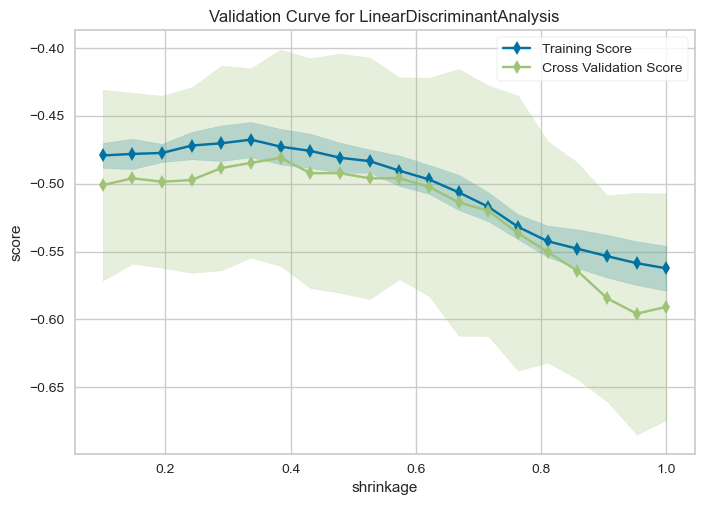

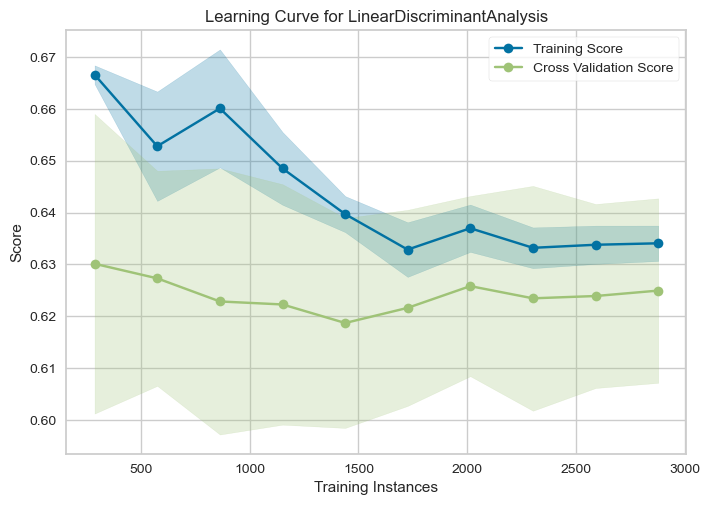

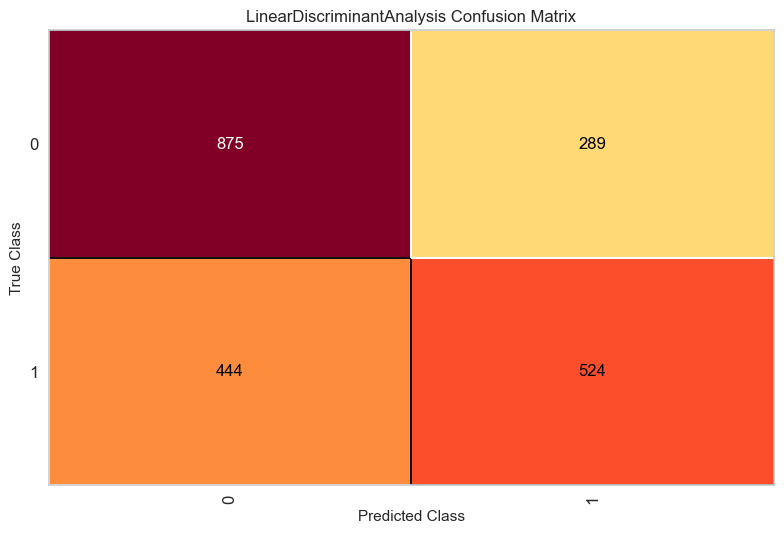

              precision    recall  f1-score   support

           0       0.66      0.75      0.70      1164
           1       0.64      0.54      0.59       968

    accuracy                           0.66      2132
   macro avg       0.65      0.65      0.65      2132
weighted avg       0.65      0.66      0.65      2132



In [29]:
from yellowbrick.classifier import ConfusionMatrix
from sklearn.metrics import classification_report


# Instanciate model
lda_2 = LinearDiscriminantAnalysis(solver='lsqr')

# Train model and use it to predict
y_pred = lda_2.fit(X_train_imputed, y_train).predict(X_test_imputed)


study_model(lda_2, X_train_imputed, y_train,'shrinkage',np.linspace(0.1, 1, 20))

# Create confusion matrix
cm = ConfusionMatrix(lda_2)
cm.fit(X_train_imputed, y_train)
cm.score(X_test_imputed, y_test)
cm.show()

# Classification report
print(classification_report(y_test, y_pred))

#### *LDA ROC and precision-call curves*

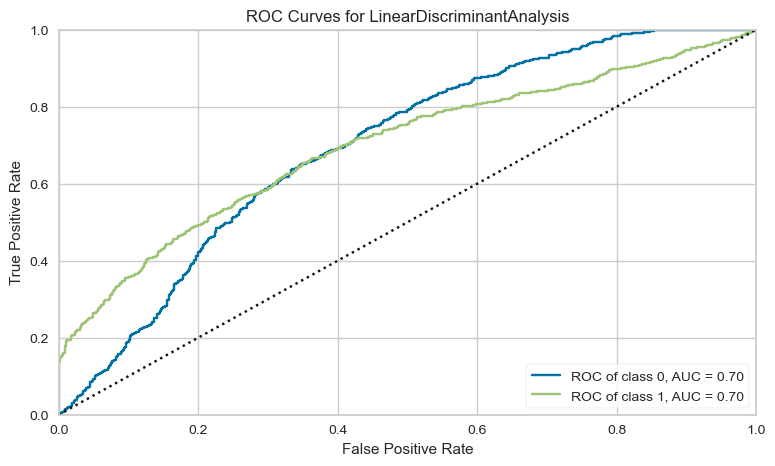

In [30]:
from yellowbrick.classifier import ROCAUC, PrecisionRecallCurve

# ROC CURVE 
# Fit visualizer to our classifier
roc_viz = ROCAUC(lda_2,
                 is_fitted=True,
                 per_class=True,
                 micro=False,
                 macro=False,
                 size=(900, 500))
roc_viz.fit(X_train_imputed, y_train)
roc_viz.score(X_test_imputed, y_test)
roc_viz.show();

### **Support Vector Machine**

The following method used is the Support Vector Machine (SVM). This supervised learning algorithm finds the hyperplane that best separates data into classes by maximizing the margin between classes. It can handle high-dimensional data and is effective in cases with clear margin separation

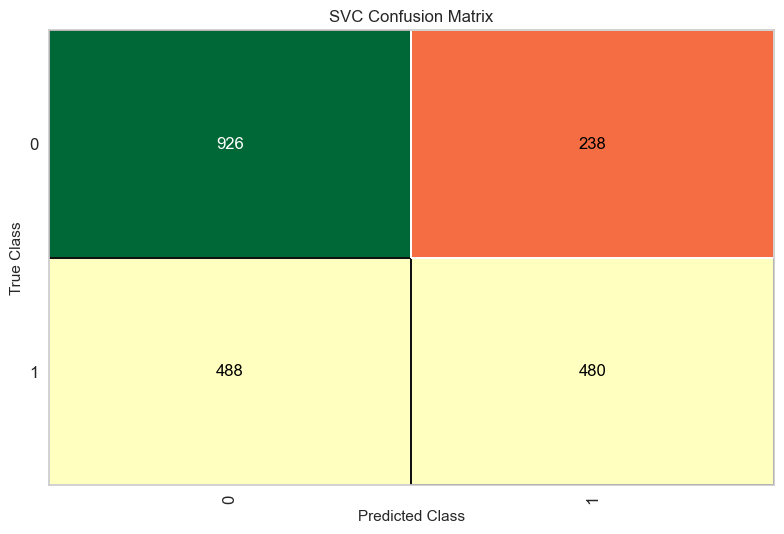

              precision    recall  f1-score   support

           0       0.80      0.65      0.72      1414
           1       0.50      0.67      0.57       718

    accuracy                           0.66      2132
   macro avg       0.65      0.66      0.64      2132
weighted avg       0.69      0.66      0.67      2132



In [31]:
# Confusion matrix
evaluate_classifier(SVC(kernel='linear'),
                    X_train_imputed,
                    y_train,
                    X_test_imputed,
                    y_test);

### **Decision Tree**

The fifth classifier method used is the Decision Tree. This model has a tree shape where each "*internal*" node represents a feature, each "*branch*" represents a decision rule, ane each "*leaf node*" represents the outcome.

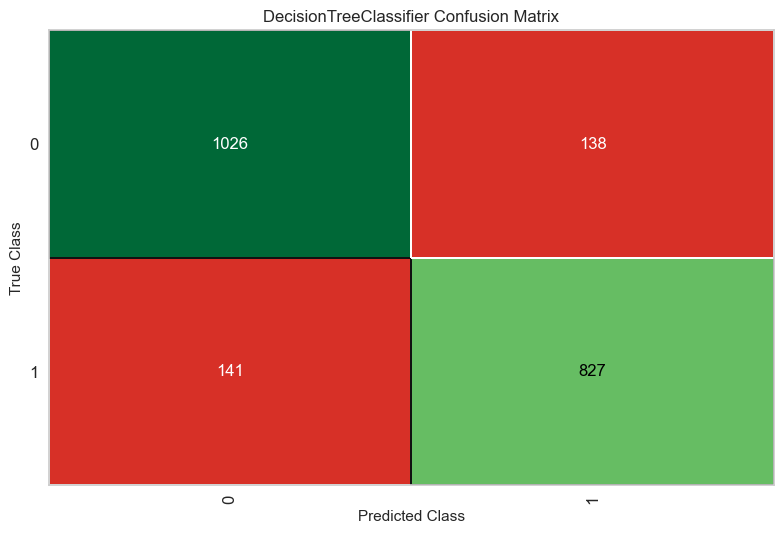

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      1167
           1       0.85      0.86      0.86       965

    accuracy                           0.87      2132
   macro avg       0.87      0.87      0.87      2132
weighted avg       0.87      0.87      0.87      2132



In [32]:
# Confusion matrix
dt = evaluate_classifier(DecisionTreeClassifier(max_depth=10, random_state=42),
                    X_train_imputed,
                    y_train,
                    X_test_imputed,
                    y_test);

# VALIDATION

In [42]:
import pandas as pd

# Load the Parquet file
validation_path = r"C:\Users\Ferran\Desktop\TFM\TFM_EEG\DATASET\MI\SUB_2\RANDOM_FILTERED\Dictionary_random.parquet"
validation_data = pd.read_parquet(validation_path)

# Count the occurrences of each value in the 'side' column
side_counts = validation_data['side'].value_counts()

print("Counts of rows for each side:")
print(side_counts)


Counts of rows for each side:
side
left     1200
right    1200
Name: count, dtype: int64


Decision Tree Evaluation Metrics:
Accuracy: 0.925
Precision: 1.0
Recall: 0.85
ROC AUC: 0.98875


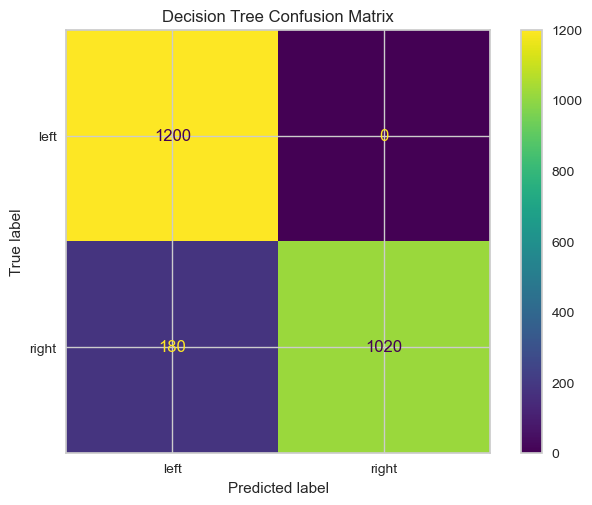

In [34]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Ensure the validation dataset has the same structure as expected
# Separate features and target
X_validation = validation_data[['rms', 'ptp', 'delta_power', 'theta_power', 'alpha_power', 'beta_power', 
                                 'gamma_power', 'hurst_exponent', 'fractal_dimension', 'kurtosis', 
                                 'skewness', 'sample_entropy', 'permutation_entropy', 'shannon_entropy', 'lziv_complexity']]
y_validation = validation_data['side']

# Initialize LabelEncoder to convert 'left' and 'right' to numeric labels
label_encoder = LabelEncoder()
y_validation_encoded = label_encoder.fit_transform(y_validation)

# Impute missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_validation)

# Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_imputed, y_validation_encoded)  # Training should ideally happen on training data, adjust as necessary

# Predict on the validation set
y_pred = dt.predict(X_imputed)
y_pred_proba = dt.predict_proba(X_imputed)[:, 1]  # Probability of class 1

# Evaluation metrics for Decision Tree
accuracy = accuracy_score(y_validation_encoded, y_pred)
precision = precision_score(y_validation_encoded, y_pred)
recall = recall_score(y_validation_encoded, y_pred)
roc_auc = roc_auc_score(y_validation_encoded, y_pred_proba)

# Print evaluation metrics
print(f"Decision Tree Evaluation Metrics:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"ROC AUC: {roc_auc}")

# Confusion Matrix for Decision Tree
confusion_matrix_dt = confusion_matrix(y_validation_encoded, y_pred)
cm_display_dt = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_dt, display_labels=label_encoder.classes_)
cm_display_dt.plot()
plt.title("Decision Tree Confusion Matrix")
plt.show()


Clear overfitting

KNN Evaluation Metrics:
Accuracy: 0.6625
Precision: 0.6681034482758621
Recall: 0.6458333333333334
ROC AUC: 0.6945815972222222


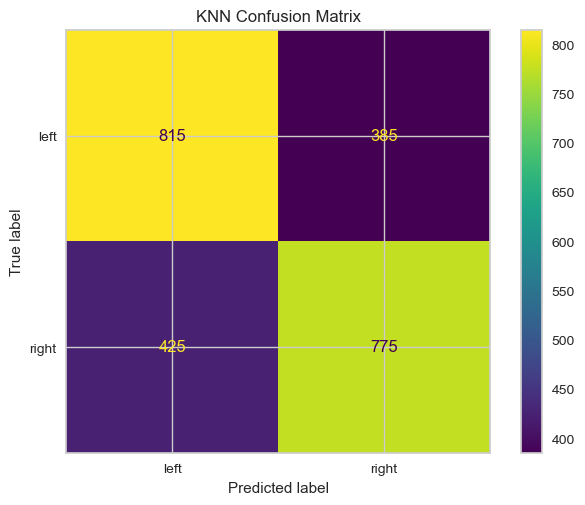

In [35]:
from sklearn.neighbors import KNeighborsClassifier

# K-Nearest Neighbors Classifier (KNN)
knn = KNeighborsClassifier(n_neighbors=3)

# Fit the KNN model on the validation dataset
# Note: Ideally, the model should be trained on the training set, but here we're using validation data for demonstration
knn.fit(X_imputed, y_validation_encoded)

# Predict on the validation set using KNN
y_pred_knn = knn.predict(X_imputed)
y_pred_proba_knn = knn.predict_proba(X_imputed)[:, 1]  # Probability of class 1

# Evaluation metrics for KNN
accuracy_knn = accuracy_score(y_validation_encoded, y_pred_knn)
precision_knn = precision_score(y_validation_encoded, y_pred_knn)
recall_knn = recall_score(y_validation_encoded, y_pred_knn)
roc_auc_knn = roc_auc_score(y_validation_encoded, y_pred_proba_knn)

# Print evaluation metrics for KNN
print(f"KNN Evaluation Metrics:")
print(f"Accuracy: {accuracy_knn}")
print(f"Precision: {precision_knn}")
print(f"Recall: {recall_knn}")
print(f"ROC AUC: {roc_auc_knn}")

# Confusion Matrix for KNN
confusion_matrix_knn = confusion_matrix(y_validation_encoded, y_pred_knn)
cm_display_knn = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_knn, display_labels=label_encoder.classes_)
cm_display_knn.plot()
plt.title("KNN Confusion Matrix")
plt.show()


SVM Evaluation Metrics:
Accuracy: 0.5025
Precision: 0.6
Recall: 0.015
ROC AUC: 0.48579166666666673


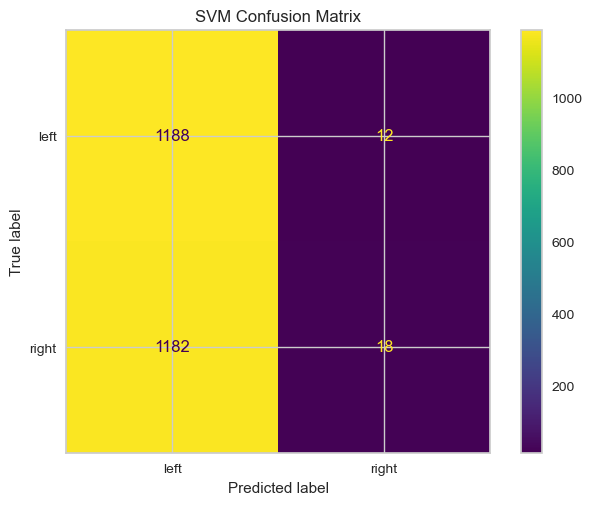

In [36]:
from sklearn.svm import SVC

# Support Vector Machine Classifier
svm = SVC(probability=True, random_state=42)

# Fit the SVM model on the validation dataset
svm.fit(X_imputed, y_validation_encoded)

# Predict on the validation set using SVM
y_pred_svm = svm.predict(X_imputed)
y_pred_proba_svm = svm.predict_proba(X_imputed)[:, 1]  # Probability of class 1

# Evaluation metrics for SVM
accuracy_svm = accuracy_score(y_validation_encoded, y_pred_svm)
precision_svm = precision_score(y_validation_encoded, y_pred_svm)
recall_svm = recall_score(y_validation_encoded, y_pred_svm)
roc_auc_svm = roc_auc_score(y_validation_encoded, y_pred_proba_svm)

# Print evaluation metrics for SVM
print(f"SVM Evaluation Metrics:")
print(f"Accuracy: {accuracy_svm}")
print(f"Precision: {precision_svm}")
print(f"Recall: {recall_svm}")
print(f"ROC AUC: {roc_auc_svm}")

# Confusion Matrix for SVM
confusion_matrix_svm = confusion_matrix(y_validation_encoded, y_pred_svm)
cm_display_svm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_svm, display_labels=label_encoder.classes_)
cm_display_svm.plot()
plt.title("SVM Confusion Matrix")
plt.show()


Random Forest Evaluation Metrics:
Accuracy: 0.925
Precision: 0.9194078947368421
Recall: 0.9316666666666666
ROC AUC: 0.9887493055555556


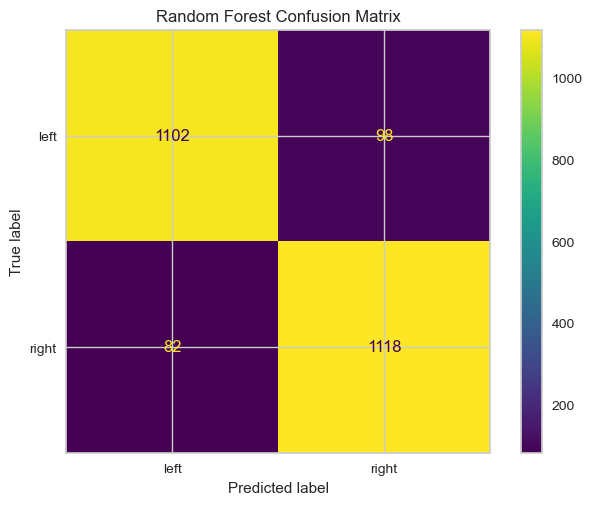

In [37]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Classifier
rf = RandomForestClassifier(random_state=42, n_estimators=100)

# Fit the Random Forest model on the validation dataset
rf.fit(X_imputed, y_validation_encoded)

# Predict on the validation set using Random Forest
y_pred_rf = rf.predict(X_imputed)
y_pred_proba_rf = rf.predict_proba(X_imputed)[:, 1]  # Probability of class 1

# Evaluation metrics for Random Forest
accuracy_rf = accuracy_score(y_validation_encoded, y_pred_rf)
precision_rf = precision_score(y_validation_encoded, y_pred_rf)
recall_rf = recall_score(y_validation_encoded, y_pred_rf)
roc_auc_rf = roc_auc_score(y_validation_encoded, y_pred_proba_rf)

# Print evaluation metrics for Random Forest
print(f"Random Forest Evaluation Metrics:")
print(f"Accuracy: {accuracy_rf}")
print(f"Precision: {precision_rf}")
print(f"Recall: {recall_rf}")
print(f"ROC AUC: {roc_auc_rf}")

# Confusion Matrix for Random Forest
confusion_matrix_rf = confusion_matrix(y_validation_encoded, y_pred_rf)
cm_display_rf = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_rf, display_labels=label_encoder.classes_)
cm_display_rf.plot()
plt.title("Random Forest Confusion Matrix")
plt.show()


Logistic Regression Evaluation Metrics:
Accuracy: 0.5125
Precision: 0.5100671140939598
Recall: 0.6333333333333333
ROC AUC: 0.5206645833333333


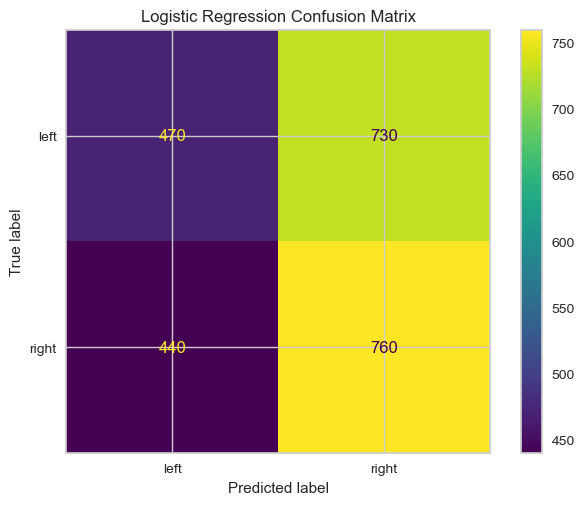

In [38]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression Classifier
lr = LogisticRegression(random_state=42, max_iter=1000)

# Fit the Logistic Regression model on the validation dataset
lr.fit(X_imputed, y_validation_encoded)

# Predict on the validation set using Logistic Regression
y_pred_lr = lr.predict(X_imputed)
y_pred_proba_lr = lr.predict_proba(X_imputed)[:, 1]  # Probability of class 1

# Evaluation metrics for Logistic Regression
accuracy_lr = accuracy_score(y_validation_encoded, y_pred_lr)
precision_lr = precision_score(y_validation_encoded, y_pred_lr)
recall_lr = recall_score(y_validation_encoded, y_pred_lr)
roc_auc_lr = roc_auc_score(y_validation_encoded, y_pred_proba_lr)

# Print evaluation metrics for Logistic Regression
print(f"Logistic Regression Evaluation Metrics:")
print(f"Accuracy: {accuracy_lr}")
print(f"Precision: {precision_lr}")
print(f"Recall: {recall_lr}")
print(f"ROC AUC: {roc_auc_lr}")

# Confusion Matrix for Logistic Regression
confusion_matrix_lr = confusion_matrix(y_validation_encoded, y_pred_lr)
cm_display_lr = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_lr, display_labels=label_encoder.classes_)
cm_display_lr.plot()
plt.title("Logistic Regression Confusion Matrix")
plt.show()
